# LANGUAGE IDENTIFICATION IN TEXTS

This notebook identifies the languages in which texts from a collection have been written. The script solves a challenge from Kaggle, the original text and the related datasets of which can be found here: https://www.kaggle.com/c/text-language-classification

Before running this script, make sure to download the two datasets, _'data-train.txt'_ and _'data-test.txt'_ in the same folder as the one in which the notebook has been cloned/downloaded. These two datasets are not provided in the repository because they weight a few hundred Mb's each.

The scores received are not great, and consist of either (0.33802, 0.35085) for TfidfVectorizer + MNB classifier, or  (0.23250, 0.23222) for the CountVectorizer + MNB classifier. They correspond to a placement in 58th position on the public leaderboard for the CountVectorizer model, or 59th position for the TfidfVectorizer model. The training dataset is however quite big, and it requires a significant computational time for fitting the model: further optimisation of the hyperparameters of the models through GridSearch is thus computationally unfeasible on my computer. The scoring computed on the training dataset is very high for both models, though, amounting to 96% for the Tfidf, and more than 99% for the CV. It is thus possible, as it will be argued later in detail, that the test dataset provided is incomplete or broken, and the scoring performed on its predictions is thus misleading.

The idea to use as feature for classification the ngrams in range (1,3), and to run the analyser on the individual characters rather than words, originates from the excellent notebook by Github user danielv775. The notebook can be found here: https://github.com/danielv775/Natural-Language-Identification-Graduate-Project/blob/master/Language%20Identification%20System%20Graduate%20Project.ipynb

Given enough computational power, it would be better to test whether a different range of ngram is a better predictor in our particular datasets. This can be tested by the reader, if interested, but it will not be done in this notebook.

# Note for Linux and MacOS-X users

I have added some acoustic signals on the course of the script to periodically inform me of the status of the computation, without having the need to look at the screen. If not using Windows, remove the next cell, and then Find and Replace the regex _winsound.Beep(.*)_ with a null string on the whole notebook before running the code, otherwise you may encounter some errors.

In [3]:
import winsound # remove if not using windows

# Basic libraries for algebra, datasets, file dumping and loading

In [4]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import pandas as pd 

import time
import pickle

# Machine learning models

We will be using the following constructors from _sklearn_:

- TfidfVectorizer: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- CountVectorizer: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- MultinomialNB:   http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
- Pipeline:        http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Read the documentation linked for a description of the characteristics of each constructor. The first three will be analysed more in detail later.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Loading the training data

The test data comes in a tab-separated file, composed by two columns and 383111 rows, with a header.

It can be easily loaded into a pandas dataframe by passing the '\t', TAB, value to the parameter _sep_.

The file occupies a bit more than 250Mb, and it may thus take a few seconds for it to load.

In [6]:
train = pd.read_csv('data-train.txt',sep='\t')
train.head()

,lang,text
0,ru,Притом же это республиканское устройство бурсы...
1,ru,"Ты упомянул о том, что могло бы привести меня ..."
2,uk,"«Отже йому і спиться, і байдуже — хропе собі!...."
3,pl,"Kiedy słońce, odchodząc za horyzont, poczęło w..."
4,ru,"Странник выудил их всех, всех до единого, и с ..."


In [7]:
train.shape

(383111, 2)

# Extracting the list of available languages

The list of languages present in the dataframe, in the order in which they first appear, can be extracted by calling the _.unique()_ method on the column of interest.

As shown below, there are 26 languages present in the training data.

In [8]:
train.sort_values('lang',inplace=True)
languages = train['lang'].unique()
len(languages), languages

(26, array(['be', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fr', 'hr', 'hsb', 'hy',
        'it', 'la', 'lt', 'lv', 'mk', 'nl', 'pl', 'pt', 'ro', 'ru', 'sk',
        'sl', 'sr', 'sv', 'uk'], dtype=object))

These 26 codes correspond to as many languages. The standard used is called ISO 639; see the comments on linguistics at the bottom of the notebook for further reference.

# Checking the distribution of languages

We can now verify whether the dataset provided contains over or under-representation of any of the languages with respect to the others. If this is the case, the ML models will receive an implicit bias in the input data, that would maybe affet their predictive capability.

In [9]:
language_distribution = train['lang'].value_counts()
language_distribution

ru     171728
en      71582
uk      33507
pl      24394
de      17509
bg      14880
be      14855
fr       9354
hy       4474
it       3353
lv       2421
nl       2155
mk       1789
cs       1787
hr       1734
sr       1704
sl       1600
sk       1588
es        767
la        497
pt        346
sv        339
ro        225
el        223
hsb       181
lt        119
Name: lang, dtype: int64

It seems like Russian and English languages are strongly overrepresented in the training dataset. Russian in particular accounts for 44% of the texts, while Russian and English together account for most, or 63%, of the whole dataset.
We can plot the frequency of each language in the dataset with the help of Pyplot.

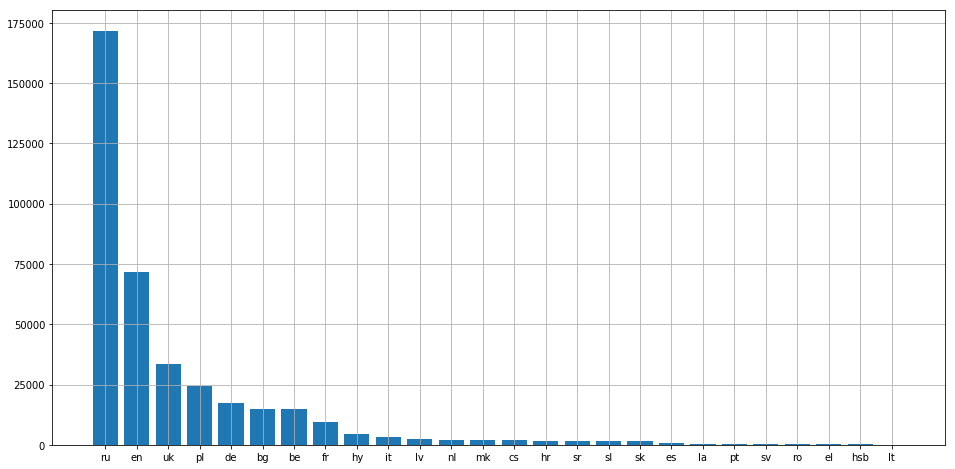

In [10]:
plt.figure(figsize=(16,8))
plt.bar(language_distribution.index,language_distribution)
plt.grid(True)
plt.show()

As can be noted by looking at the bar graph above, some languages are clearly overrepresented in the dataset. While it is not going to be the case for this particular dataset, if the _.score()_ method of the trained ML model shows an unsatisfactory result, it might become necessary to either normalize the data in preprocessing, or to provide to the ML model with batches of training samples that contain a uniform distribution of languages.

For now, we will however continue with preprocessing and cleaning the dataset, and perform some more exploratory analysis. The score computed on not-normalised data is high enough, and we will thus not bother with normalisation.

This peculiar distribution however allows us to develop a baseline for evaluating the performance of our ML model. Since almost half of the texts belong the the 'ru' category, a naive approach that predicts all texts as belonging to 'ru' would be correct almost half of the times, and specifically in 44% of the cases. Any ML model whose accuracy is lower than that would thus be unsatisfactory.

In [11]:
train['lang'] = train['lang'].astype('category')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383111 entries, 351196 to 355843
Data columns (total 2 columns):
lang    383111 non-null category
text    383108 non-null object
dtypes: category(1), object(1)
memory usage: 6.2+ MB


The cell above converts the values in the 'lang' column of the dataframe to categorical data, in order to reduce the memory consumption of the same. This process is also generally advisable when performing classification: in fact, if the classes for the data show no relationship and no overlapping, it becomes important not to provide the ML model with labels that could be ordered in any manner. It is worth to remember that string objects allow for "less than" and "greater than" methods to be called, and that this could affect the predictive capacity of the model.

The cell below tests whether categorical objects, as opposed to strings, can be compared and ordered

In [12]:
a_str = 'a'
b_str = 'b'
print('Is \'a\' < \'b\'? {}'.format(a_str<b_str)) # String objects can be oredered

a_cat = pd.Categorical('a')
b_cat = pd.Categorical('b')
try:
    print('Is \'a\' < \'b\'? {}'.format(a_cat<b_cat))
except TypeError:
    print('Error! Unordered Categoricals can only compare equality or not')

Is 'a' < 'b'? True
Error! Unordered Categoricals can only compare equality or not


# Removing null values

The training datasets comes with some null values for the text column. It was asked to the creator of the competition whether this was intended or not, and it was answered that yes, this was intended. We will thus identify the null strings of text, but they will not be removed from the dataset.
Source: https://www.kaggle.com/c/text-language-classification/discussion/23924

However, in order to feed those rows to the model, it will be necessary to convert the NaN values to empty strings, otherwise the Vectorizers will raise an error.
This is done by the next cell.

In [13]:
mask = train['text'].isnull()
train.loc[mask,'text'] = ''
train[mask]

,lang,text
40881,en,
336268,lv,
180209,mk,


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383111 entries, 351196 to 355843
Data columns (total 2 columns):
lang    383111 non-null category
text    383111 non-null object
dtypes: category(1), object(1)
memory usage: 6.2+ MB


We can now see that there are no more null values in our datasets.

It is now worth checking whether the texts are uniformally distributed in size, or whether some languages tend to have texts, whose size is significantly different from the average size of texts in other languages.

To do this, we can add a new column in our dataframe, by applying the len(string) function over the text column. We will then compute some statistical measures on the length of the texts.

In [15]:
train['length'] = train['text'].apply(len)
train.head()

,lang,text,length
351196,be,"А я б… Баюся, што я змяніўся ў твары, стаў стр...",347
336229,be,"Справа датыкалася аднаго кантроля, вельмі адда...",521
76362,be,"Я зачыню вас у яго пакоях. Добра?"" Я згадзiўся...",419
310408,be,Я быў побач з чымсьці... З чымсьці фантастычны...,509
34685,be,"“Следчы казаў, што хваробы ёсць такая, псіхічн...",414


In [16]:
train['length'].describe()

count    383111.000000
mean        470.844766
std         184.298463
min           0.000000
25%         402.000000
50%         444.000000
75%         503.000000
max       20083.000000
Name: length, dtype: float64

It looks like the range of length for the texts in the datasets is sufficiently large, varying from 0, the null strings we converted earlier, to a significantly higher 20'083. However, most of the texts have a length which gravitates between 400 and 500 characters.

We can represent the distribution of length per languages by grouping the length column of the dataframe by languages, and plotting a boxplot of the figures.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


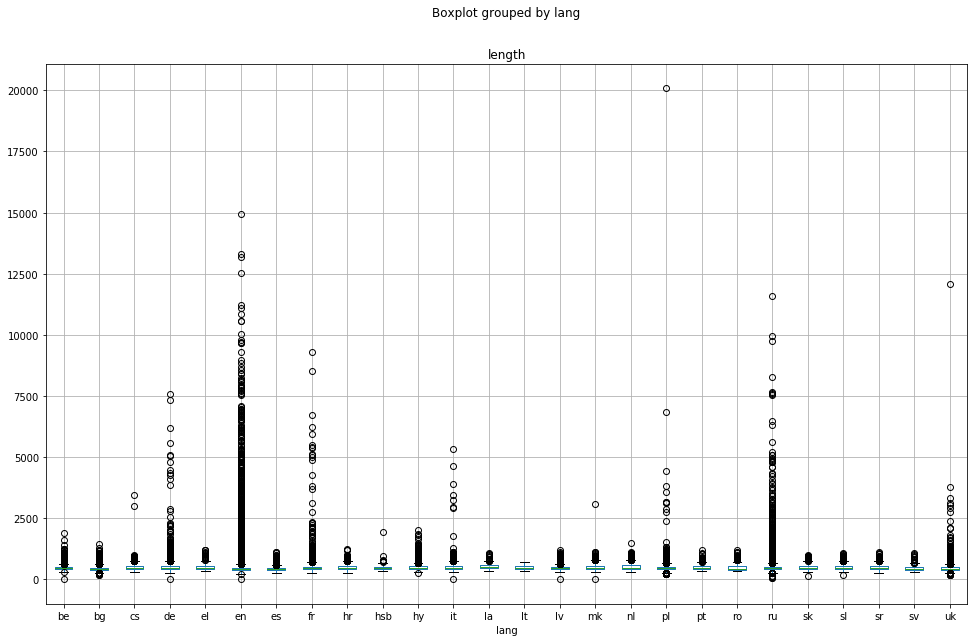

In [17]:
train.boxplot(column='length',
              by='lang', # Equivalent to calling .groupby('lang') on the whole dataframe before plotting
              figsize=(16,10))
plt.show()

As can be seen above, most texts in all languages have similar measures of central tendencies (the thin blue horizontal lines near the bottom of the graph).

The (many) texts containing significantly more characters than the average are considered to be statistical outliers, and are representend as black circles in the graph above. 

After fitting the models, the score received on this dataset, without normalising the length of the outliers, is considered to be sufficiently high. We can thus avoid normalising the texts on the basis of their length, as this can retrospectively judged to be unnecessarily. Keep however in mind that when working with other datasets it might become necessarily to normalise the length in the various texts before feeding them to the model for training. In this case, it is normally enough to cut the length of the longer texts down to the length of the 99th percentile or so.

# Loading the test data

The test data comes in a second tab-separated file, consisting of a header and a bit less than 400'000 rows.

In [18]:
test = pd.read_csv('data-test.txt',sep='\t',encoding='utf-8')
test.head()

,id,text
0,1,В нескольких шагах от последнего городского ог...
1,2,"Зараз, на відстані від того світу, того життя,..."
2,3,Траур и подавленность висели над всем бальбино...
3,4,"В трюмовете откриха релси, конструкции за желе..."
4,5,"Well, said I, coolly, ""if you will not give hi..."


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395286 entries, 0 to 395285
Data columns (total 2 columns):
id      395286 non-null int64
text    395278 non-null object
dtypes: int64(1), object(1)
memory usage: 6.0+ MB


As can be seen above, the exact number of rows is 395285. The algorithm of Kaggle for the automatic evaluation of the results however expects the number of rows to be exactly 400'000, and the rows provided are thus insufficient. A solution computed on this test dataset, as it is, will be rejected by the evaluator.

It is unclear whether the organiser of the challenge has provided an incomplete dataset as part of the difficulty to overcome, or whether the missing rows are an oversight. The issue can however be solved by reindexing the dataframe with a new index, comprised of all values between 1 and 400'000, and filling the missing rows with blank spaces. The predictions will be then computed on the correctly indexed strings provided in the test dataset, and on the blank spaces added this way.

While performing predictions on blank spaces is sure to decrease the score we will receive from Kaggle, this is the only way I could find that allows to submit the file with the solutions.

In [20]:
test = test.set_index('id') # First we set the index of the dataframe to the ID column
test.head()

,text
id,
1,В нескольких шагах от последнего городского ог...
2,"Зараз, на відстані від того світу, того життя,..."
3,Траур и подавленность висели над всем бальбино...
4,"В трюмовете откриха релси, конструкции за желе..."
5,"Well, said I, coolly, ""if you will not give hi..."


In [21]:
new_index = pd.Index(np.arange(1,400001,1), name="id") # Then we create a new index object, ranging from 1 to 400'000,
                                                       # as requested by the automatic evaluator.
new_index

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            399991, 399992, 399993, 399994, 399995, 399996, 399997, 399998,
            399999, 400000],
           dtype='int64', name='id', length=400000)

In [22]:
test = test.reindex(new_index) # Then we reindex the dataframe with the indices newly created.
                               # This process will insert null rows where values were missing in the old index.
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 1 to 400000
Data columns (total 1 columns):
text    395278 non-null object
dtypes: object(1)
memory usage: 6.1+ MB


In [23]:
test['text'].fillna(' ',inplace=True) # The empty rows are filled with blanks
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 1 to 400000
Data columns (total 1 columns):
text    400000 non-null object
dtypes: object(1)
memory usage: 6.1+ MB


# Pointers to the input variables and the labels

Preprocessing is now complete. We should now create pointers to the training texts and labels, and feed them to the ML models.

Although it is not mandatory to use the following notation, this is a good practice, as it is common in ML applications to call the input variables to a model with the letter 'X', uppercase, and the target labels with the letter 'y', lowercase.

In [24]:
X = train['text']
y = train['lang']

# First model: TfidfVectorizer + MultinomialNB

### TfidfVectorizer

As a preliminary hypothesis, I asked myself how to reduce the impact for the model of the overrepresentation of certain languages in the corpus of documents.

The "IDF" in Tfidf stands for "Inverse Document Frequency", and denotes a value by which all tokens are multiplied when creating the sparse matrix for the vectorizer. Specifically, it is a penalty for those tokens which are strongly represented across the whole corpus of documents, and it is multiplied by the term frequency of the same token.
Computationally, the inverse document frequency _idf(t)_ of token t is calculated with the follwing expression:

$$idf(t) = \log{\frac{1+n_d}{1+df(d,t)}}+1$$

For example, if we are computing the idf for the following bigram _t = ('h','i')_, in the collection of documents (383111) provided as training data, and the number of documents in which the bigram appears is 10'000, the _idf_ of t is then:

$$n_d = 383111$$

$$df(d,t) = 10000$$

$$idf(t) = \log{\frac{1+383111}{1+10000}}+1 = 2.343$$

This value is then multiplied by the term frequency of the token; that is, by the number of times the token appears in a document, divided by the total number of tokens present. The resulting product is assigned to the TF-IDF matrix, in the column corresponding to the token itself, and the row corresponding to the row assigned to the document on which TF-IDF for that token was computed.

Source: http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

### Multinomial Naive Bayes

Please note: the MNB classifier is not meant to work with the fractional term frequencies that are output by TfidfVectorizer, but only with integer values, such as those output by CountVectorizer. However, as stated in the sklearn documentation, "in practice fractional counts such as tf-idf may also work". After testing, they work in this case.

The MNB classifier computes the probability distribution that, given the features of a text, this text belongs to each of the classes that were observed during training.

The most important parameter for instantiating the MNB classifier is its alpha value, which defaults to 1 if left unspecified, as it is our case. If alpha == 1, the MNB classifier performs on its underlying weighs an operation called "Laplace smoothing". Some authors suggest that this type of smoothing is the most effecting for performing categorical classification on texts.

Source on the MNB classifier: http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

Source on Laplace smoothing as the best smoothing for text classification: https://en.wikipedia.org/wiki/Additive_smoothing#cite_note-2

In [25]:
winsound.Beep(440,3000) # Beeps when starting instantiation of the pipeline

In [26]:
pipeline = Pipeline([('tfidf',TfidfVectorizer(analyzer='char',
                                             ngram_range=(1,3))),
                     ('mnb',MultinomialNB())
                    ])

t = time.time()
pipeline.fit(X,y)
print('Computation done in {} seconds'.format(int(time.time()-t)))

print('Score: \n',pipeline.score(X,y))

Computation done in 782 seconds
Score: 
 0.9622642001926335


The above takes about 12 minutes

In [27]:
winsound.Beep(440,3000) # Beeps when finishing .fit() and .score()

# Saving the TFIDF model

In [28]:
with open('model_TF.pkl','wb') as f:
    pickle.dump(pipeline,f,protocol=-1)

In [29]:
with open('model_TF.pkl','rb') as f:
    pipeline = pickle.load(f)

# Predicting class probabilities with TFIDF

The next cell predicts the probability distribution for each class of language for each text of the test dataframe.

The operation is computationally expensive, and requires about 20 minutes on my CPU.

It is interesting to notice how often, when using ML models other than neural networks, fitting and performing predictions on datasets of similar sizes require more or less the same amount of time.

In [30]:
t0 = time.time()
predictions = pipeline.predict_proba(test['text']) # This takes about 15 min
print(time.time()-t0)
predictions[:3]

925.4644854068756


array([[1.15874510e-13, 4.08482644e-09, 7.50220558e-33, 1.40962092e-33,
        1.33677742e-33, 5.29614208e-33, 6.64397902e-33, 5.35268144e-32,
        5.63647339e-33, 2.26613504e-33, 1.88957674e-33, 3.77395925e-32,
        4.72010201e-33, 8.84157538e-34, 4.16083468e-33, 4.35825170e-18,
        1.05276057e-32, 2.75646862e-37, 3.37313161e-33, 2.01669555e-33,
        9.99999937e-01, 4.64693772e-33, 6.21291061e-33, 7.42554173e-23,
        3.31842505e-33, 5.89239425e-08],
       [6.37779210e-12, 1.65219993e-12, 1.46489250e-31, 6.86137537e-33,
        3.82752762e-32, 2.10205078e-33, 1.67206633e-31, 6.38044969e-31,
        1.16301367e-31, 6.09960412e-32, 3.15465403e-32, 5.98715365e-31,
        1.21908395e-31, 2.48383817e-32, 1.16016592e-31, 2.88093001e-19,
        2.22776278e-31, 1.23618608e-36, 8.64120921e-32, 5.31172792e-32,
        5.33790289e-10, 9.53361964e-32, 1.29372431e-31, 3.43926981e-23,
        8.58975623e-32, 9.99999999e-01],
       [9.10873246e-15, 2.69508097e-09, 6.78676877e-34

# Saving the predictions for submission

In [31]:
submissions_TF = pd.DataFrame(predictions,index=test.index,columns=languages)
submissions_TF.to_csv('submissions_TF.csv')
print('Done')
winsound.Beep(440, 3000)

Done


In [32]:
submissions_TF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 1 to 400000
Data columns (total 26 columns):
be     400000 non-null float64
bg     400000 non-null float64
cs     400000 non-null float64
de     400000 non-null float64
el     400000 non-null float64
en     400000 non-null float64
es     400000 non-null float64
fr     400000 non-null float64
hr     400000 non-null float64
hsb    400000 non-null float64
hy     400000 non-null float64
it     400000 non-null float64
la     400000 non-null float64
lt     400000 non-null float64
lv     400000 non-null float64
mk     400000 non-null float64
nl     400000 non-null float64
pl     400000 non-null float64
pt     400000 non-null float64
ro     400000 non-null float64
ru     400000 non-null float64
sk     400000 non-null float64
sl     400000 non-null float64
sr     400000 non-null float64
sv     400000 non-null float64
uk     400000 non-null float64
dtypes: float64(26)
memory usage: 82.4 MB


# Second model: CountVectorizer + MultinomialNB

### CountVectorizer

CountVectorizer extracts the absolute frequency of each term in each sample, and assigns it to the appropriate position in the output matrix. More in detail, the output matrix has, as columns, each of the tokens in the observed training dataset, and, as rows, each of the observed documents. The output matrix is thus comprised of lots of 0's, corresponding to the tokens not present in a particular document, and some positive integer values, corresponding to the number of times a token is observed in a given document.

Calculating the output matrix for the CountVectorizer, assuming one uses the same parameters as those for the TfidfVectorizer, should in theory take less time. In practice, however, it does not, and running the model in the next cell requires more or less the same time as the previous model. I presume that most of the computational time required goes into parsing the text data and forming the dictionary of ngrams, rather than performing the additional computations required for TfidfVectorizer, as opposed to the more simple CountVectorizer. This assumption is however unproven.

### Multinomial Naive Bayes

See "First model", above.

In [33]:
pipeline = Pipeline([('countvec',CountVectorizer(analyzer='char',
                                             ngram_range=(1,3))),
                     ('mnb',MultinomialNB())
                    ])

t = time.time()
pipeline.fit(X,y)
print('Computation done in {} seconds'.format(int(time.time()-t)))

print('Score: \n',pipeline.score(X,y))

Computation done in 775 seconds
Score: 
 0.9938764483400372


The previous cell should take about 15 minutes.

In [34]:
winsound.Beep(440, 3000)

# Saving the CV model

In [35]:
with open('model_CV.pkl','wb') as f:
    pickle.dump(pipeline,f,protocol=-1)

In [36]:
with open('model_CV.pkl','rb') as f:
    pipeline = pickle.load(f)

# Predicting the class affiliation

We can now compute the probability distribution that each text belongs to a given class.

The cell below performs this task.

In [37]:
t0 = time.time()
predictions = pipeline.predict_proba(test['text'])
print(time.time()-t0)
predictions[:3]

924.5734193325043


array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 1.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 9.69755534e-303],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.000

The cell above takes about 15 min

In [38]:
submissions_CV = pd.DataFrame(predictions,index=test.index,columns=languages)
submissions_CV.to_csv('submissions_CV.csv')
print('Done')
winsound.Beep(440, 3000)

Done


In [39]:
submissions_CV.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 1 to 400000
Data columns (total 26 columns):
be     400000 non-null float64
bg     400000 non-null float64
cs     400000 non-null float64
de     400000 non-null float64
el     400000 non-null float64
en     400000 non-null float64
es     400000 non-null float64
fr     400000 non-null float64
hr     400000 non-null float64
hsb    400000 non-null float64
hy     400000 non-null float64
it     400000 non-null float64
la     400000 non-null float64
lt     400000 non-null float64
lv     400000 non-null float64
mk     400000 non-null float64
nl     400000 non-null float64
pl     400000 non-null float64
pt     400000 non-null float64
ro     400000 non-null float64
ru     400000 non-null float64
sk     400000 non-null float64
sl     400000 non-null float64
sr     400000 non-null float64
sv     400000 non-null float64
uk     400000 non-null float64
dtypes: float64(26)
memory usage: 82.4 MB


# Conclusion

The job is done, and the two files, 'submission_TF.csv' and 'submission_CV.csv' are ready to be uploaded to Kaggle.

I suggest zip'ing or rar'ing the files before submitting them, as they occupy a few hundred Mb each.

The second model, the one with CountVectorizer, performs better, however slightly. As the overall result on the leaderboard for both models is however low, one can infer, that significantly better models were used by the people in the top positions.

Although the competition is over, it is not known what models those were. It is judged unlikely that additional preprocessing of the training data could have given a better score on the test data, since the score received in classifying the training data for both models is sufficiently high (96% for the one with Tfidf and 99% for the one with CV). It is therefore assumed that a more complex model was used by those in the top positions, and maybe one involving deep learning.

It is also possible that the file containing the test data was corrupted or replaced at a late time in the history of the competition since, as we have seen earlier, many of its elements were null. While this may happen on real datasets used for training, it is unlikely that a human would want to test the predictive capacity of a model on test data which contains empty values, associated with non-empty labels. It is however not possible to determine whether this is the case, because the file with the test labels was not made public.

# On linguistics

As suggested by the score computed on the training dataset, it seems that the assumption provided by Github user danielv775, cited earlier, is valid on this dataset too. That is, CountVectorizer + MultinomialNB correctly identify (score higher than 99%) most of the languages in a dataset. Additionally, it seems that ngram_range=(1,3) (that is, unigrams, bigrams, and trigrams) works very well.

### We now have a trained model for identifying languages in general texts

As a side result of the computation above, our trained model can now be used to correctly identify the language in text not seen in either the training or the test datasets. The cells below show how to do it.

If the trained model needs to be used in a different script, just load it with pickle from the saved file into a pipeline object, making sure to have loaded all relevant libraries first. You can then use it to predict the language of a corpus of texts by passing them to the .predict() method of the pipeline, as a list. The output is a list of language labels for each document in the input list.

Remember: the languages on which the model has been trained are the 26 languages seen in the training dataset:

    ['be', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fr', 'hr', 'hsb', 'hy',
        'it', 'la', 'lt', 'lv', 'mk', 'nl', 'pl', 'pt', 'ro', 'ru', 'sk',
        'sl', 'sr', 'sv', 'uk']

These language codes are provided accordingly to the ISO 639 standard.
More on ISO 639 here: https://en.wikipedia.org/wiki/ISO_639

Text not belonging to any of the languages above would not be correctly identified by the model.

In [40]:
sentence = 'Gal gali kalbėti lėčiau?' # 'Can you speak slowly?', in Lithuanian
pipeline.predict([sentence]) # Note the square brackets, Method .predict() expects an iterable.
# expected 'lt'

array(['lt'], dtype='<U3')

In [41]:
sentence = 'Bunicii mei au un cal.' # 'My grandparents have a horse.', in Romenian
pipeline.predict([sentence])
# expected 'ro'

array(['ro'], dtype='<U3')

In [42]:
sentence = 'Hrvatski jedan od najtežih jezika' # 'Croatian is one of the hardest languages', in Croatian
pipeline.predict([sentence])
# expected 'hr'

array(['hr'], dtype='<U3')

In [43]:
sentence = 'Hej! Jag är brittisk.' # 'Hello! I am British', in Swedish
pipeline.predict([sentence])
# expected 'sv'

array(['sv'], dtype='<U3')

In [44]:
sentences = ['A melhor defesa é o ataque',  # 'The best defence is the attack', in Portuguese
            'On ne fait pas d\'omelette sans casser des oeufs'] 
                        # 'It is not possible to make omelettes without breaking eggs', in French

pipeline.predict(sentences) # Note we are not using the square brackets here, since "sentences" is already a list.
# expected pr, fr

array(['pt', 'fr'], dtype='<U3')

The next cell informs the user with a celebratory melody that all computations are done; remove if not using Windows.

In [45]:
C = 261
E = 329
G = 392
C_UP = 523
for i in range(5):
    winsound.Beep(C,1000)
    winsound.Beep(E,1000)
    winsound.Beep(G,1000)
    winsound.Beep(C_UP,1000)